<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp16_save_gpt_embeddings_chatgptDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook downloads Mohammad's chatGPT-generated datasetand and queries every sentence's text embedding from openai's api.

# Install and Import

In [ ]:
!pip install -q datasets rouge_score openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.1 MB/s eta 0:00:00


In [ ]:
# import packages

import openai
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.metrics.pairwise import cosine_similarity
from functools import partial
from time import sleep
pd.set_option('display.min_rows', 4)
tqdm.pandas()
tqdm = partial(tqdm, position=0, leave=True)

# Download dataset and split it into sentences

In [ ]:
# load dataset into a dataframe

!wget -qO "Mohammad_dataset_result(3).json" https://uoguelphca-my.sharepoint.com/:u:/g/personal/mhavaled_uoguelph_ca/ET_4hgQABD5JhtiDtFGUG4gBASpIv6WURezHphMTlPCJqg?download=1
data = json.load(open('Mohammad_dataset_result(3).json'))
df = (pd.DataFrame(data)
      .rename(columns={'paragraphs': 'article'})
      )
df

,article,key_sentences
0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...
1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...
...,...,...
1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...
1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ..."


In [ ]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 1260/1260 [00:02<00:00, 574.25it/s]


,article,key_sentences,sentences
0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...,[Climate change is one of the most pressing is...
1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...,[Education is the key to unlocking a better fu...
...,...,...,...
1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...,[The environment plays a critical role in our ...
1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ...",[Family is an essential component of our lives...


In [ ]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 1260/1260 [00:02<00:00, 620.92it/s]


,article,key_sentences,sentences
0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...,[Climate change is one of the most pressing is...
1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...,[Education is the key to unlocking a better fu...
...,...,...,...
1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...,[The environment plays a critical role in our ...
1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ...",[Family is an essential component of our lives...


In [ ]:
df['is_key'] = df.progress_apply(
    lambda x: (
        [int(x.key_sentences in s) for s in x.sentences]
    ),
    axis=1
)
df = df[df.is_key.apply(sum) == 1]      # keep those paragraphs which have only one key sentence
df = df[df.is_key.apply(len) > 1]       # keep those paragraphs which consist of multiple sentences
df = df.reset_index()
df

100%|██████████| 1260/1260 [00:00<00:00, 10114.03it/s]


,index,article,key_sentences,sentences,is_key
0,0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...,[Climate change is one of the most pressing is...,"[0, 0, 0, 1]"
1,1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...,[Education is the key to unlocking a better fu...,"[0, 0, 0, 1]"
...,...,...,...,...,...
1241,1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...,[The environment plays a critical role in our ...,"[0, 0, 0, 1]"
1242,1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ...",[Family is an essential component of our lives...,"[0, 0, 0, 0, 1]"


In [ ]:
# get all individual sentences
all_sentences = []
for i, row in df.iterrows():
    all_sentences += row['sentences']

# make a dataframe of sentences
df_sent = pd.DataFrame({
    'sentence': all_sentences,
    'embedding': [np.NaN]*len(all_sentences)
})
df['embedding'] = np.NaN
df['embedding'] = df['embedding'].astype(object)

df_sent

,sentence,embedding
0,Climate change is one of the most pressing iss...,NaN
1,The rise in global temperatures due to human a...,NaN
...,...,...
4591,"Conflicts and misunderstandings can arise, lea...",NaN
4592,"In such cases, it is important to communicate ...",NaN


# Get openai's (GPT) embeddings 

In [ ]:
# check connection and authentication with openai
MODEL_TO_USE = 'text-embedding-ada-002'
API_KEY = open('api_key.txt').read()        # the api_key is in a separate txt file

openai.api_key = API_KEY
res = [obj for obj in openai.Engine.list()['data']
       if obj['id'] == MODEL_TO_USE][0]
print(res)

{
  "created": null,
  "id": "text-embedding-ada-002",
  "object": "engine",
  "owner": "openai-internal",
  "permissions": null,
  "ready": true
}


## Sentence embeddings

In [ ]:
# request for openai's embeddings through api #

BATCH_SIZE = 2000    # sentences per api request

# this loop saves received embeddings every iteration
# when error occurs at any request (iteration), just re-run the loop and
# it will skip those saved batches and start from the batch which error occured
for i in range(0, len(df_sent), BATCH_SIZE):
    start, stop = i, min(i+BATCH_SIZE, len(df_sent))
    print(f'from: {start}, to: {stop}')

    # skip if results of this batch has saved
    if df_sent.loc[start:stop, 'embedding'].notna().all():
        continue

    sentences_to_query = df_sent.loc[start:stop].sentence.tolist()
    res = openai.Embedding.create(
        input=sentences_to_query,
        engine=MODEL_TO_USE
    )
    X = np.array([r['embedding'] for r in res['data']])

    for j, k in enumerate(range(start, stop)):
        df_sent.at[k, 'embedding'] = 'a_random_string'      # to avoid error, somehow we need to initialize this cell with "something" first
        df_sent.at[k, 'embedding'] = X[j]
    
    sleep(1)    # avoid requesting too fast

from: 0, to: 2000
from: 2000, to: 4000
from: 4000, to: 4593


In [ ]:
# save sentences embeddings
df_sent.to_pickle('exp16_df_sent_chatgptDS.dfpkl')

## Article and highlights embeddings

In [ ]:
# request for openai's embeddings through api
def get_embeddings(df, inp_col, outp_col, batch_size=500, model='text-embedding-ada-002', verbose=True):

    df[outp_col] = np.NaN
    df[outp_col] = df[outp_col].astype(object)

    # this loop saves received embeddings every iteration
    # when error occurs at any request (iteration), just re-run the loop and
    # it will skip those saved batches and start from the batch which error occured
    for i in range(0, len(df), batch_size):
        start, stop = i, min(i+batch_size, len(df))
        
        if verbose:
            print(f'from: {start}, to: {stop}')

        # skip if results of this batch has saved
        if df.loc[start:stop, outp_col].notna().all():
            continue

        res = openai.Embedding.create(
            input=df.loc[start:stop][inp_col].tolist(),
            engine=model,
        )
        X = np.array([r['embedding'] for r in res['data']])

        for k, j in enumerate(range(start, stop)):
            df.at[j, outp_col] = 'an_random_string'
            df.at[j, outp_col] = X[k]
            
        
        sleep(1)    # avoid requesting too fast

    return df
    
BATCH_SIZE = 500
df = get_embeddings(df, 'article', 'article_emb', BATCH_SIZE, MODEL_TO_USE)
df

from: 0, to: 500
from: 500, to: 1000
from: 1000, to: 1243


,index,article,key_sentences,sentences,is_key,embedding,article_emb
0,0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...,[Climate change is one of the most pressing is...,"[0, 0, 0, 1]",NaN,"[-0.0008796413894742727, -0.013974178582429886..."
1,1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...,[Education is the key to unlocking a better fu...,"[0, 0, 0, 1]",NaN,"[-0.008942407555878162, -0.012576048262417316,..."
...,...,...,...,...,...,...,...
1241,1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...,[The environment plays a critical role in our ...,"[0, 0, 0, 1]",NaN,"[0.027159251272678375, -0.018947456032037735, ..."
1242,1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ...",[Family is an essential component of our lives...,"[0, 0, 0, 0, 1]",NaN,"[0.008778269402682781, 0.00871442724019289, 0...."


In [ ]:
BATCH_SIZE = 500
df = get_embeddings(df, 'key_sentences', 'key_sent_emb', BATCH_SIZE, MODEL_TO_USE)
df

from: 0, to: 500
from: 500, to: 1000
from: 1000, to: 1243


,index,article,key_sentences,sentences,is_key,embedding,article_emb,highlights_emb,key_sent_emb
0,0,Climate change is one of the most pressing iss...,We need to act urgently to reduce our greenhou...,[Climate change is one of the most pressing is...,"[0, 0, 0, 1]",NaN,"[-0.0008796413894742727, -0.013974178582429886...",NaN,"[-0.014789319597184658, -0.024009281769394875,..."
1,1,Education is the key to unlocking a better fut...,It is crucial that we invest in education at a...,[Education is the key to unlocking a better fu...,"[0, 0, 0, 1]",NaN,"[-0.008942407555878162, -0.012576048262417316,...",NaN,"[-0.006444304715842009, -0.015827901661396027,..."
...,...,...,...,...,...,...,...,...,...
1241,1258,The environment plays a critical role in our l...,It is our responsibility to take care of the e...,[The environment plays a critical role in our ...,"[0, 0, 0, 1]",NaN,"[0.027159251272678375, -0.018947456032037735, ...",NaN,"[0.0234543364495039, -0.018231311812996864, -0..."
1242,1259,Family is an essential component of our lives....,"In such cases, it is important to communicate ...",[Family is an essential component of our lives...,"[0, 0, 0, 0, 1]",NaN,"[0.008778269402682781, 0.00871442724019289, 0....",NaN,"[-0.009183181449770927, 0.009393483400344849, ..."


In [ ]:
# save sentences embeddings
df.to_pickle('exp16_df_art_chatgptDS.dfpkl')

# Check results

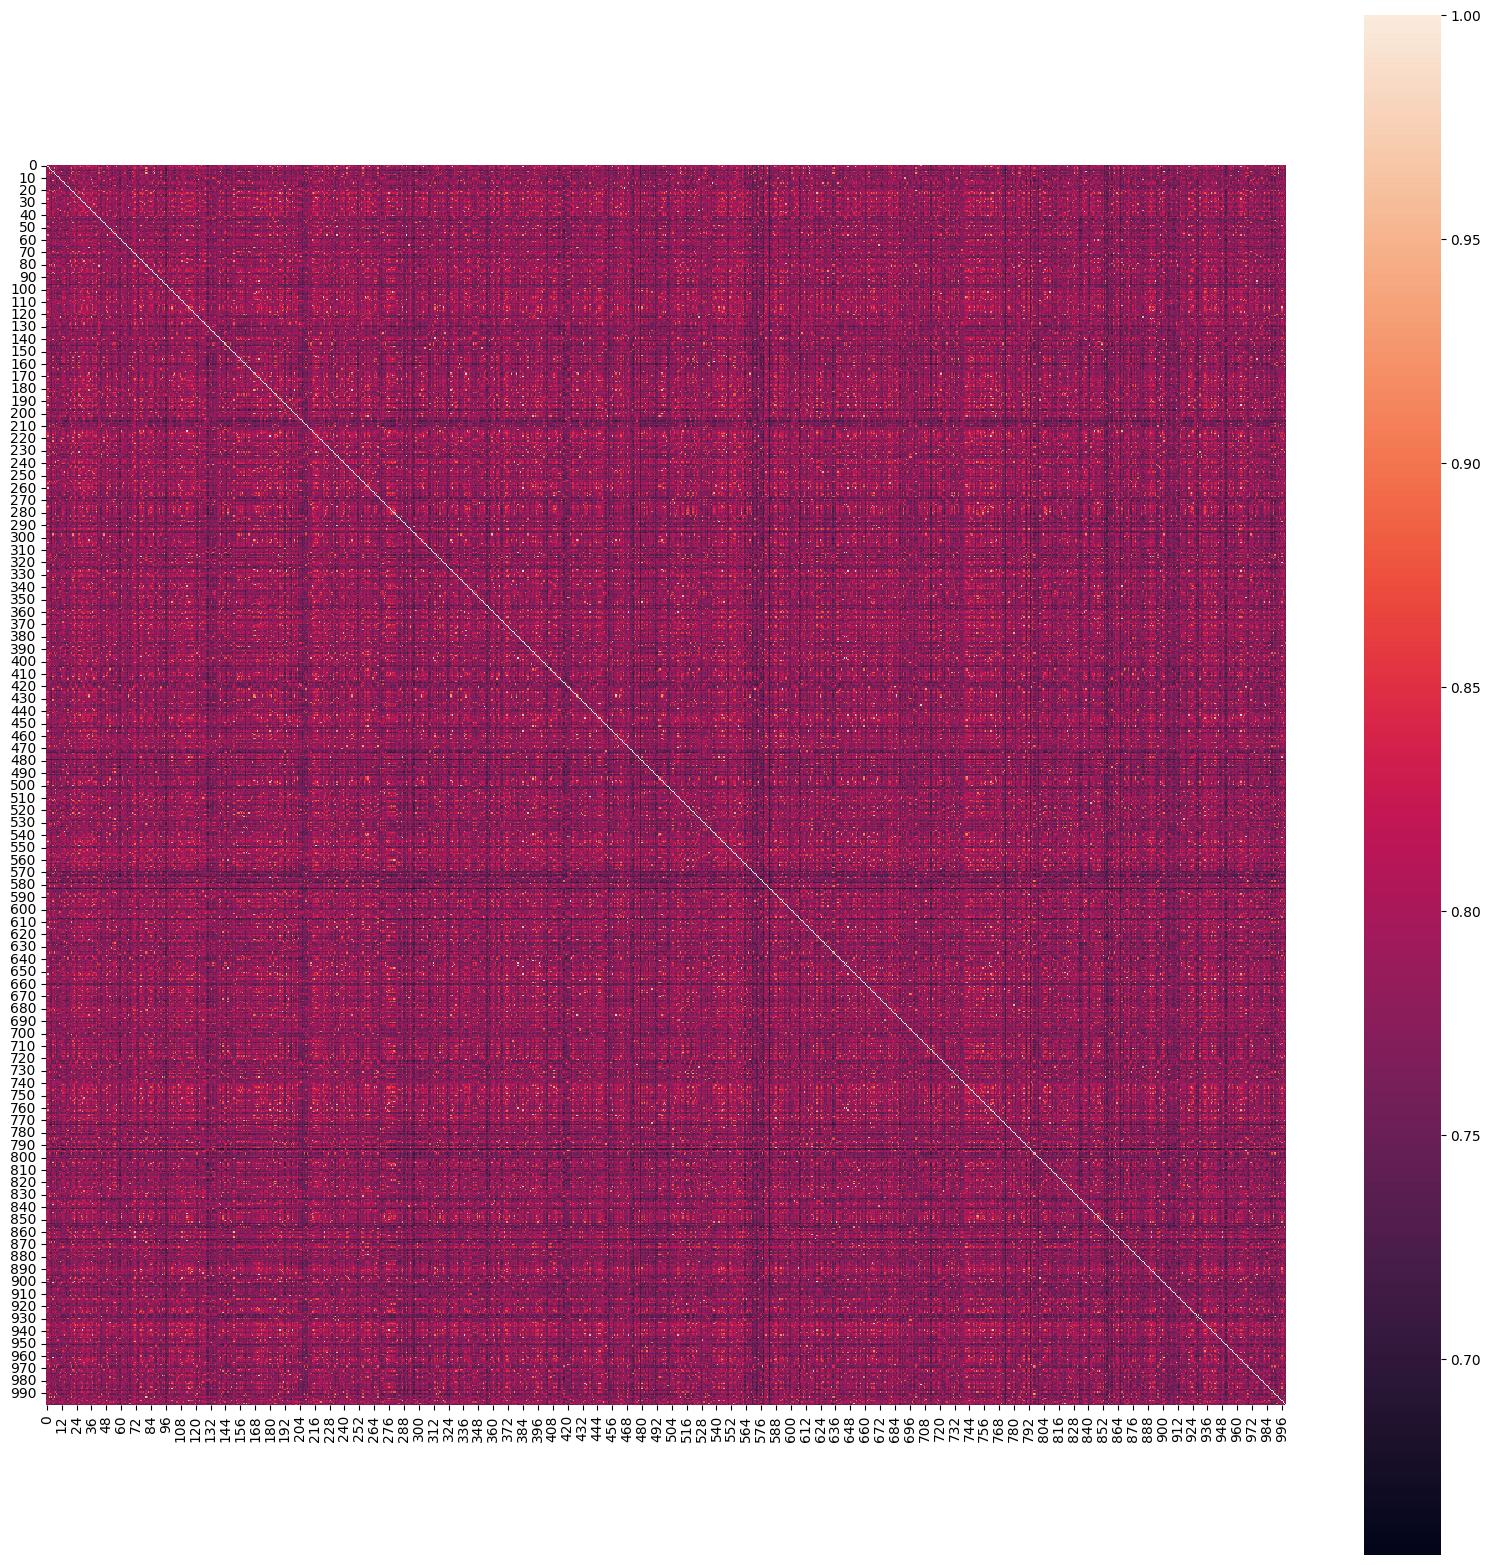

In [ ]:
# sentence-to-sentence similarities

def fix_ndarray(emb_values):
    return np.array([[u for u in v] for v in emb_values])
    
df_sampled = df_sent.sample(1000)
X = fix_ndarray(df_sampled.embedding.values)
A = cosine_similarity(X, X)

plt.figure(figsize=(20,20))
sns.heatmap(A)
plt.gca().set_aspect('equal')
plt.show()

Text(0.5, 1.0, 'distribution of sampled cos-sim')

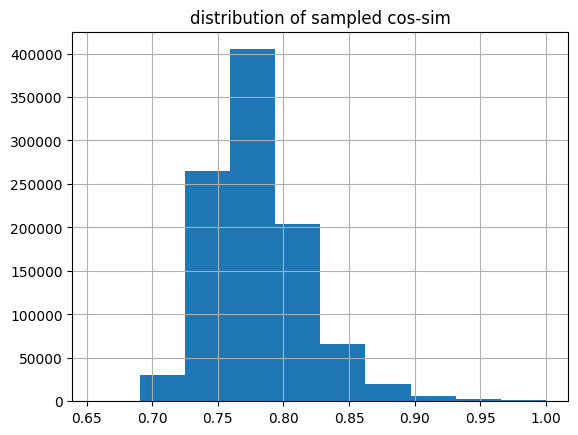

In [ ]:
# histogram

pd.Series(A.flat).hist()
plt.title('distribution of sampled cos-sim')

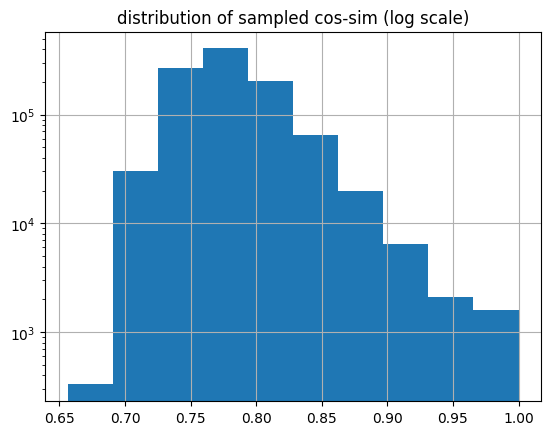

In [ ]:
# histogram (log scale)

pd.Series(A.flat).hist()
plt.yscale('log')
plt.title('distribution of sampled cos-sim (log scale)')
plt.show()

In [ ]:
# # for backup
# from google.colab import drive
# drive.mount('/gdrive')
# !cp *.dfpkl /gdrive/MyDrive/Shared/